   Author: Ankit Kariryaa, University of Bremen
   
   Modified by Jiawei Wei

In [1]:
from tensorflow.keras.models import load_model
import numpy as np               # numerical array manipulation
import pandas as pd
import os
import time
from collections import defaultdict
from functools import reduce
from PIL import Image

import geopandas as gps
import rasterio                  # I/O raster data (netcdf, height, geotiff, ...)
import rasterio.warp             # Reproject raster samples
# import fiona
import shapely
import shapely.ops as ops
from shapely.geometry import Point, Polygon
from shapely.geometry import mapping, shape
# import fiona
import cv2
from tqdm import tqdm
# import geopandas as gps
import rasterio.mask
import affine

from core.UNet import UNet
from core.losses_FTL import focalTversky, accuracy, dice_coef, dice_loss, specificity, sensitivity, PA, IoU_Pos, IoU_Neg, mIoU, F1_Score
from core.optimizers import adaDelta, adagrad, adam, nadam
from core.frame_info_evaluate_withLocation import FrameInfo
from core.dataset_generator import DataGenerator
from core.split_frames import split_dataset
from core.visualize import display_images

%matplotlib inline
import matplotlib.pyplot as plt  # plotting tools
import matplotlib.patches as patches

import warnings                  # ignore annoying warnings
warnings.filterwarnings("ignore")
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

%reload_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

import tensorflow as tf
print(tf.__version__)

2.5.0-rc3


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
config = ConfigProto(
    #device_count={"CPU": 64},
    allow_soft_placement=True, 
    log_device_placement=False)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.7 
session = InteractiveSession(config=config)

In [3]:
# Initialize the data related variables used in the notebook

# For reading the WST and annotated images generated in the step - 1
base_dir = r'I:\Unet\v1\v1\notebooks'
image_type = '.tif'
WST_fn = 'delta'
annotation_fn = 'annotation'

path_to_write = os.path.join(r'I:\results\SST\landsat\extractWithLocation', 'extract50_withLocation')
print(path_to_write)
# For testing, images are divided into sequential patches
patch_generation_stratergy = 'sequential'
patch_size = (256,256,3)
BATCH_SIZE = 16 # Model is evaluated in batches; See https://keras.io/models/model/#evaluate
patch_dir = r'I:\Unet\v1\v1\notebooks\patches{}'.format(patch_size[0])
frames_json = os.path.join(patch_dir,'frames_list.json')

# # When stratergy == sequential
step_size = (256,256)


# The data has four channels
input_shape = (256,256,2)
input_image_channel = [0, 1]
input_label_channel = [2]


OPTIMIZER = adam 
LOSS =focalTversky

#Only for the name of the model in the very end
OPTIMIZER_NAME = 'adam'
LOSS_NAME = 'focalTversky'

modelToEvaluate = os.path.join(base_dir, r'saved_models\UNet\plumes_normalized_20220106-2216_adam_focalTversky_012_256.h5')
print(modelToEvaluate)

I:\results\SST\landsat\extractWithLocation\extract50_withLocation
I:\Unet\v1\v1\notebooks\saved_models\UNet\plumes_normalized_20220106-2216_adam_focalTversky_012_256.h5


In [4]:
#File path for final report 
timestr = time.strftime("%Y%m%d-%H%M")
chf = input_image_channel + input_label_channel
chs = reduce(lambda a,b: a+str(b), chf, '')

evaluation_report_path = model_path = os.path.join(base_dir, 'evaluationreport') 
if not os.path.exists(evaluation_report_path):
    os.makedirs(evaluation_report_path)
evaluation_report_filename = os.path.join(evaluation_report_path,'evaluation_per_pixel{}_{}.csv'.format(timestr,chs))
print(evaluation_report_filename)

I:\Unet\v1\v1\notebooks\evaluationreport\evaluation_per_pixel20220422-1720_012.csv


In [5]:
# Read all images/frames into memory
frames = []

all_files = os.listdir(path_to_write)
all_files_WST = [fn for fn in all_files if fn.startswith(WST_fn) and fn.endswith(image_type)]
len(all_files_WST)
for i, fn in enumerate(tqdm(all_files_WST)):
    WST_img = rasterio.open(os.path.join(path_to_write, fn))

    read_WST_img = WST_img.read()
    read_WST_img = np.nan_to_num(read_WST_img, nan=-255)
    WST_img_meta = WST_img.meta

    comb_img = np.transpose(read_WST_img, axes=(1,2,0))
    annotation_im = rasterio.open(os.path.join(path_to_write, fn.replace(WST_fn,annotation_fn)))
    annotation = annotation_im.read()[0]

    f = FrameInfo(comb_img, annotation, WST_img_meta)
    frames.append(f)

4786

100%|██████████████████████████████████████████████████████████████████████████████| 4786/4786 [09:17<00:00,  8.59it/s]


In [6]:
# For testing on all frames. All sequential frames are kept in memory and this may create memory related errors in some cases. 
# testing_frames  = list(range(len(frames)))
training_frames, validation_frames, testing_frames  = split_dataset(frames, frames_json, patch_dir)

annotation_channels = input_label_channel 
test_generator = DataGenerator(input_image_channel, patch_size, testing_frames, frames, annotation_channels)

# Sequential generate all patches from the all frames
test_patches = test_generator.all_sequential_patches(step_size)
print('Total patches to evaluate the model on: ' + str(len(test_patches[0])))

Reading train-test split from file
training_frames [2490, 1698, 323, 234, 3977, 1533, 440, 675, 2848, 1908, 204, 2803, 529, 4024, 2381, 1303, 3459, 2815, 819, 2483, 3060, 2068, 2066, 3059, 4014, 4406, 22, 2506, 1690, 255, 4036, 0, 3038, 3073, 678, 836, 1513, 701, 3019, 3528, 1855, 1930, 3052, 1001, 2187, 4458, 2054, 437, 227, 2145, 3609, 2189, 3596, 1521, 2147, 2824, 2503, 2797, 221, 284, 1528, 2396, 2354, 1538, 317, 533, 832, 1668, 3066, 294, 1853, 2322, 821, 532, 275, 2837, 4414, 1302, 332, 3703, 1637, 834, 1534, 2072, 3042, 230, 2055, 541, 549, 1661, 3980, 15, 1535, 4455, 1154, 304, 282, 1148, 1640, 2461, 1061, 287, 684, 2362, 2058, 258, 2458, 2064, 4007, 2073, 2804, 276, 4417, 680, 2368, 3056, 1137, 3527, 2213, 1150, 984, 2493, 4031, 2810, 2811, 2827, 3710, 2352, 1934, 1004, 2391, 2365, 2763, 1642, 2326, 1000, 4020, 288, 2469, 2818, 3983, 2370, 442, 236, 687, 4016, 690, 2504, 2071, 3704, 4026, 211, 3697, 1638, 3612, 1694, 1517, 2394, 1639, 312, 3719, 2834, 1147, 822, 1006, 2056, 36

(548, 256, 256, 2)
(548, 2)


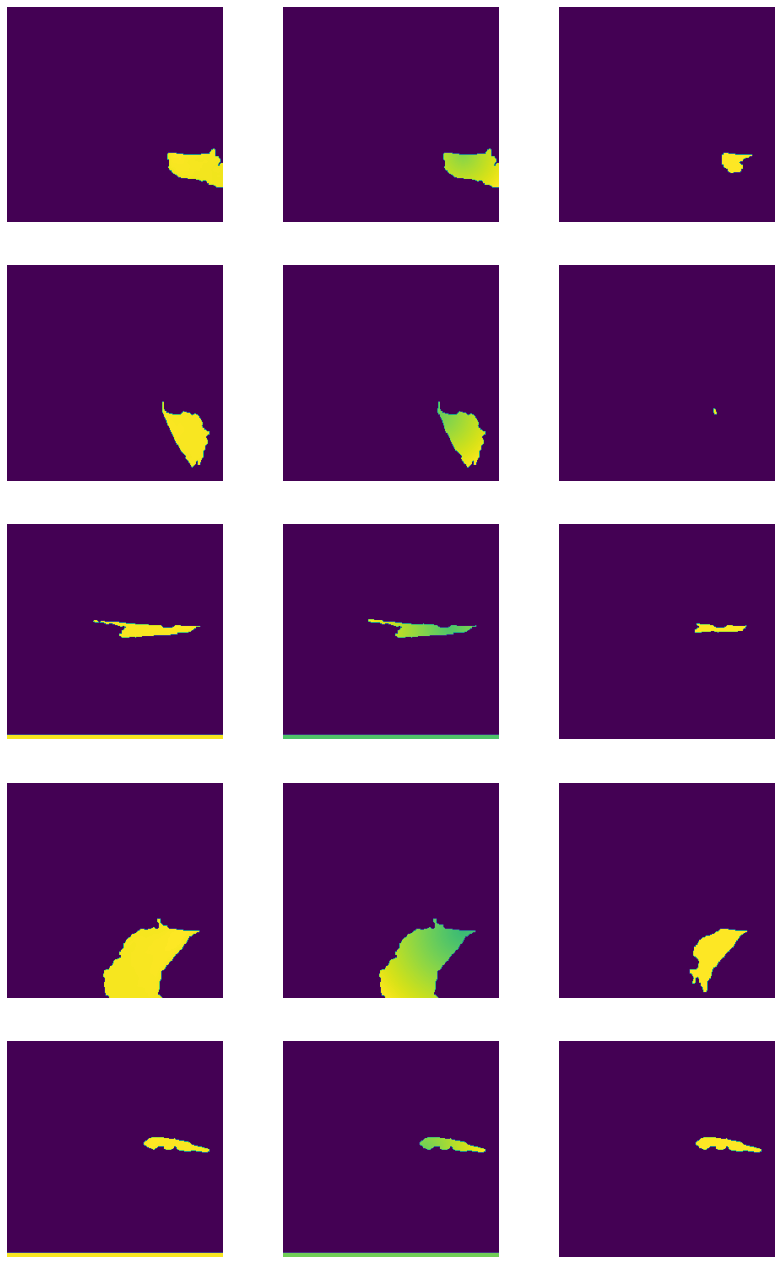

In [7]:
#Display the some of the test images
numberOfImagesToDisplay = 5

train_images, real_label = test_patches[0][:numberOfImagesToDisplay], test_patches[1][:numberOfImagesToDisplay]
print(test_patches[0].shape)
print(test_patches[2].shape)
display_images(np.concatenate((train_images,real_label), axis = -1))

In [8]:
#Evaluate model
def evaluate_model(model_path, evaluation_report_filename):
    print(model_path, evaluation_report_filename)
    model = load_model(model_path, custom_objects={'focalTversky': LOSS, 'dice_coef': dice_coef, 'dice_loss':dice_loss, 'accuracy':accuracy , 'specificity': specificity, 'sensitivity':sensitivity, 'PA':PA, 'IoU_Pos':IoU_Pos, 'IoU_Neg':IoU_Neg, 'mIoU':mIoU, 'F1_Score':F1_Score}, compile=False)#, 'IoU_Pos':IoU_Pos, 'IoU_Neg':IoU_Neg, 'mIoU':mIoU, 'F1_Score':F1_Score
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[dice_coef, dice_loss, accuracy, specificity, sensitivity, PA, IoU_Pos, IoU_Neg, mIoU, F1_Score]) #, IoU_Pos, IoU_Neg, mIoU, F1_Score
    print('Evaluating model now!')
    ev = model.evaluate(x=test_patches[0], y=test_patches[1], batch_size=16, verbose=1, use_multiprocessing=False)
    report  = dict(zip(model.metrics_names, ev))
    report['model_path'] =  model_path
    report['test_frame_dir']= base_dir
    report['total_patch_count']= len(test_patches[0])
    
    return report

report = evaluate_model(modelToEvaluate, evaluation_report_filename)


I:\Unet\v1\v1\notebooks\saved_models\UNet\plumes_normalized_20220106-2216_adam_focalTversky_012_256.h5 I:\Unet\v1\v1\notebooks\evaluationreport\evaluation_per_pixel20220422-1720_012.csv
Evaluating model now!
35/35 [==============================] - 11s 100ms/step - loss: 0.1052 - dice_coef: 0.9974 - dice_loss: 0.0026 - accuracy: 0.9977 - specificity: 0.9991 - sensitivity: 0.8709 - PA: 0.9977 - IoU_Pos: 0.8061 - IoU_Neg: 0.9976 - mIoU: 0.9018 - F1_Score: 0.8913


100%|████████████████████████████████████████████████████████████████████████████████| 548/548 [02:20<00:00,  3.91it/s]


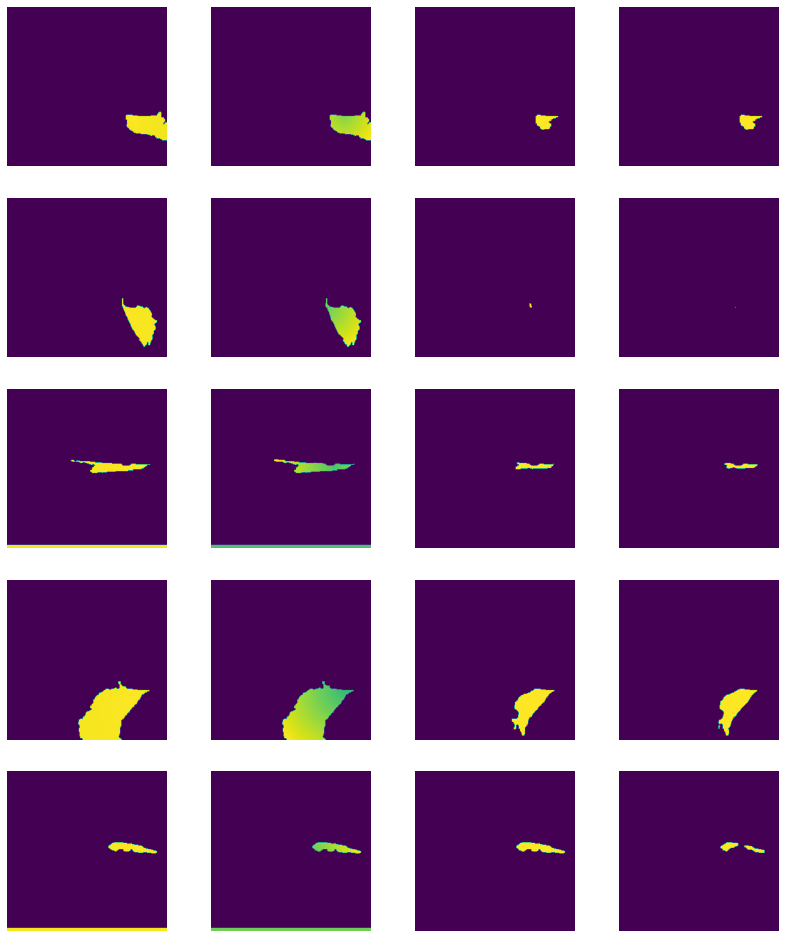

In [9]:
# Show the model predictions!
model = load_model(modelToEvaluate, custom_objects={'focalTversky': LOSS, 'dice_coef': dice_coef, 'dice_loss':dice_loss, 'accuracy':accuracy , 'specificity': specificity, 'sensitivity':sensitivity, 'mIoU':mIoU, 'PA':PA, 'IoU_Pos':IoU_Pos, 'IoU_Neg':IoU_Neg, 'mIoU':mIoU, 'F1_Score':F1_Score}, compile=False)
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[dice_coef, dice_loss, accuracy, specificity, sensitivity, mIoU, PA, IoU_Pos, IoU_Neg, mIoU, F1_Score])
outpatches=r'I:\results\SST\landsat\evaluate50'
outlabels=r'I:\results\SST\landsat\test_label50'
outimgs=r'I:\results\SST\landsat\test_img50'
# load patch meta tempelate for further edition
with rasterio.open(r'I:\results\SST\landsat\extractWithLocation\extract50_withLocation\delta_0_Angra_LC08_218076_20130708.tif') as raster_template:
    meta_template = raster_template.meta 
    
predictions = []
for i, tp in enumerate(tqdm(test_patches[0])):
    tpx = np.expand_dims(tp, axis=0)
    modelpredtictions = model.predict(tpx, batch_size=BATCH_SIZE)
#     modelpredtictions[modelpredtictions>0.5]=1
#     modelpredtictions[modelpredtictions<=0.5]=0
    modelpredtictions = np.squeeze(modelpredtictions, axis = 3) #remove axis with length 1
    img = np.transpose(test_patches[0][i], axes=(2,0,1))
    img = img.astype('float32')
    label_mask = np.transpose(test_patches[1][...,[0]][i], axes=(2,0,1))
    label_mask = label_mask.astype('float32')
    modelpredtictions[label_mask==0]=0 #limit prediction in label
    # save ndarray of pathces to tif
    patch_lonlat_ul = test_patches[2][i]
    patch_lon_left = patch_lonlat_ul[0]
    patch_lat_up = patch_lonlat_ul[1]
    patch_transform = affine.Affine(0.00025, 0.0, patch_lon_left, 0.0, -0.00025, patch_lat_up)
    patch_meta = meta_template.copy()
    patch_meta.update({
              "dtype": 'float32',
              "height": patch_size[0],
              "width": patch_size[1],
              "transform": patch_transform,
              "compress": 'lzw'}) #
    patch_meta_pred = patch_meta.copy()
    patch_meta_pred.update({"count": 1})
    with rasterio.open(outpatches+'/patches50_'+str(i)+'.tif', 'w', **patch_meta_pred) as prediction_patch_dataset:
        prediction_patch_dataset.write(modelpredtictions)
        predictions.append(np.transpose(modelpredtictions, axes=(1,2,0)))
    with rasterio.open(outlabels+'/label50_'+str(i)+'.tif', 'w', **patch_meta_pred) as label_patch_dataset:
        label_patch_dataset.write(label_mask)
    with rasterio.open(outimgs+'/img50_'+str(i)+'.tif', 'w', **patch_meta) as img_patch_dataset:
        img_patch_dataset.write(img)
display_images(np.concatenate((test_patches[0][:numberOfImagesToDisplay], test_patches[1][...,[0]][:numberOfImagesToDisplay], predictions[:numberOfImagesToDisplay]), axis = -1))

In [10]:
# Transform Contours from image to world coordinates  
def transform_contours_to_xy(contours, transform):
    tp = []
    for cnt in contours:
        pl = cnt[:, 0, :]
        cols, rows = zip(*pl)
        x,y = rasterio.transform.xy(transform, rows, cols)
        if type(x)==np.float64:
            print(cols, rows, x, y, pl)
            tl = [(x, y)]
        else:
            tl = [list(i) for i in zip(x, y)]
        tp.append(tl)
    return (tp)

def mask_to_polygons(mask, transform, j, th = 0.5):
    # first, find contours with cv2: it's much faster than shapely and returns hierarchy
    mask[mask < th] = 0
    mask[mask >= th] = 1
    mask = ((mask) * 255).astype(np.uint8)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    c_len1 = len(contours)
    #Convert contours from image coordinate to xy coordinate (world coordinates)
    contours = transform_contours_to_xy(contours, transform)
    c_len2 = len(contours)
#     print(contours)
    if contours : #some children contours are omitted in transform_xy    and (c_len1 == c_len2) 
        print(f'Finish contours/polygons detected in: {j+1} / {len(test_patches[0])}')
    else: #TODO: Raise an error maybe
        print(f'No detected in: {j+1} / {len(test_patches[0])}')
        return [Polygon()]
    
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
#     print(hierarchy[0])
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
#             print(cnt_children, parent_idx, idx)
#             print(len(contours))
            cnt_children[parent_idx].append(contours[idx])             
    # create actual polygons filtering by area/hole (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(contours):
        if idx not in child_contours and len(cnt)>=3: #and cv2.contourArea(cnt) >= min_area: 
            try:
#                 print(cnt)
#                 print(cnt_children)
                poly = Polygon(
                    shell=cnt, #
                    holes=[c for c in cnt_children.get(idx, [])])
                           #if cv2.contourArea(c) >= min_area]) 
#                 print(poly)
                all_polygons.append(poly)
            except Exception as e: 
                print(e)
                pass
#     print(len(all_polygons))
    return(all_polygons)

In [11]:
import pyproj    
# import shapely
# import shapely.ops as ops

def transform_to_meter_coordinate_system(geom):
    # TODO: Remove the hard coded values
    project = pyproj.Transformer.from_proj(
        pyproj.Proj(init='epsg:4326'), # source coordinate system
        pyproj.Proj(init='epsg:8857')) # destination coordinate system 8857
    gt = ops.transform(project.transform, geom)  # apply projection
    return gt

def ha_area(ha_polygons):
    ts = 0
    ha_polygons_meter = [transform_to_meter_coordinate_system(p) for p in ha_polygons]
    for p in ha_polygons_meter:
        ts += p.area
    return ts

def ha_area_polygons(ha_polygons):
    polygons_number=0
    ha_polygons_meter = [transform_to_meter_coordinate_system(p) for p in ha_polygons]
    for p in ha_polygons_meter:
#         if p.area > 0.03*(10**6):#minarea=0.015*10^6
        polygons_number =polygons_number+1
#     area_polygonsnumber=np.concatenate([ts,polygons_number],axis=1)
    return polygons_number


# def ha_area_from_mask(mask, th = 0.5):
#     mask[mask < th] = 0
#     mask[mask >= th] = 1
# #     totalMaskArea = 256*256/4
#     plumeArea = mask.sum()/4 # Divide by 4, since we use a resolution of 50cm/pixel
#     return plumeArea

# TODO: Remove the need for the a tiff file for transformation


ha_prediction_polygons = []
ha_label_polygons = []
    
ha_prediction_plume_area = []
ha_label_plume_area = []

for em, pred in enumerate(predictions):
    with rasterio.open(r'I:\results\SST\landsat'+r'\evaluate50'+r'\patches50_'+str(em)+'.tif') as raster_image:
        transform = raster_image.meta['transform']
    
    ap = mask_to_polygons(pred, transform, em)
    ha_prediction_polygons.append(ap)
#     ha_prediction_plume_area.append(ha_area_from_mask(pred))

for i, lb in enumerate(test_patches[1][...,[0]]):
    with rasterio.open(r'I:\results\SST\landsat'+r'\evaluate50'+r'\patches50_'+str(i)+'.tif') as raster_image:
        transform = raster_image.meta['transform']
    
    ap = mask_to_polygons(lb, transform, i)
    ha_label_polygons.append(ap)
#     ha_label_plume_area.append(ha_area_from_mask(lb))

Finish contours/polygons detected in: 1 / 548
No detected in: 2 / 548
Finish contours/polygons detected in: 3 / 548
Finish contours/polygons detected in: 4 / 548
Finish contours/polygons detected in: 5 / 548
Finish contours/polygons detected in: 6 / 548
Finish contours/polygons detected in: 7 / 548
Finish contours/polygons detected in: 8 / 548
Finish contours/polygons detected in: 9 / 548
(105,) (184,) -82.75292927397186 28.96227215478759 [[105 184]]
Finish contours/polygons detected in: 10 / 548
Finish contours/polygons detected in: 11 / 548
Finish contours/polygons detected in: 12 / 548
Finish contours/polygons detected in: 13 / 548
(253,) (144,) -2.3914511769134164 55.96592779035192 [[253 144]]
Finish contours/polygons detected in: 14 / 548
Finish contours/polygons detected in: 15 / 548
Finish contours/polygons detected in: 16 / 548
Finish contours/polygons detected in: 17 / 548
Finish contours/polygons detected in: 18 / 548
Finish contours/polygons detected in: 19 / 548
Finish cont

In [12]:
ha_prediction_polygons_count = [len(hp) for hp in ha_prediction_polygons]
ha_label_polygons_count = [len(hp) for hp in ha_label_polygons]

ha_prediction_plume_area= list(map(ha_area, ha_prediction_polygons))
ha_prediction_polygons_number=list(map(ha_area_polygons, ha_prediction_polygons))

ha_label_plume_area= list(map(ha_area, ha_label_polygons))
ha_label_polygons_number=list(map(ha_area_polygons, ha_label_polygons))
# Alternate method to calcualte plume area 
print('To calculate the area we convert the polygons to a coordinate system where unit is meters. This process is time consuming.')
ha_prediction_plume_area = list(map(ha_area, ha_prediction_polygons))
ha_label_plume_area = list(map(ha_area, ha_label_polygons))

In [13]:
len(ha_prediction_plume_area)
len(ha_label_plume_area)
pd.Series(ha_label_plume_area, ha_prediction_plume_area)

548

548

2.979340e+05    2.988800e+05
0.000000e+00    9.067096e+03
1.234745e+05    1.706640e+05
1.151439e+06    1.241616e+06
2.066334e+05    4.020441e+05
                    ...     
1.878576e+05    1.878576e+05
3.569696e+05    3.786096e+05
8.146341e+05    9.348235e+05
7.792171e+05    9.152366e+05
1.301625e+05    1.333066e+05
Length: 548, dtype: float64

In [14]:
from scipy.stats import pearsonr
print(len(ha_prediction_polygons_count))
ha_count_correlation = pearsonr(ha_prediction_polygons_count, ha_label_polygons_count)
ha_area_correlation = pearsonr(ha_prediction_plume_area, ha_label_plume_area)

print('Count correlation:' + str(ha_count_correlation))
print('Area correlation:' + str(ha_area_correlation))

548
Count correlation:(0.0675206354092887, 0.1143795353419899)
Area correlation:(0.9573115259530828, 1.7782338064397027e-296)


In [15]:
ha_label_plume_area_km2 = [x/1e6 for x in tqdm(ha_label_plume_area)]
ha_prediction_plume_area_km2 = [x/1e6 for x in tqdm(ha_prediction_plume_area)]
len(ha_label_plume_area_km2)
len(ha_prediction_plume_area_km2)
pd.Series(ha_label_plume_area_km2, ha_prediction_plume_area_km2)
# for i_idx,i_v in enumerate(ha_label_plume_area_km2):
#     for j_idx, j_v in enumerate(ha_prediction_plume_area_km2):
#         if i_v<j_v:
#             del ha_label_plume_area_km2[i_idx]
#             del ha_prediction_plume_area_km2[j_idx]     
# len(ha_label_plume_area_km2)
# len(ha_prediction_plume_area_km2)

100%|████████████████████████████████████████████████████████████████████████████████████████| 548/548 [00:00<?, ?it/s]


548

548

0.297934    0.298880
0.000000    0.009067
0.123474    0.170664
1.151439    1.241616
0.206633    0.402044
              ...   
0.187858    0.187858
0.356970    0.378610
0.814634    0.934824
0.779217    0.915237
0.130163    0.133307
Length: 548, dtype: float64

([<matplotlib.axis.YTick at 0x268b79861c0>,
 <a list of 5 Text major ticklabel objects>)

([<matplotlib.axis.XTick at 0x268b79b29d0>,
 <a list of 5 Text major ticklabel objects>)

(0.0, 2.0)

(0.0, 2.0)

Text(0.125, 1.25, 'Slope: 0.849\n$R^2$: 0.916\nRMSE: 0.129\nPatch:548')

Text(0.05, 1.05, '(a)')

Text(0.5, 0, 'Label area (${km^2}$)')

Text(0, 0.5, 'Prediction area (${km^2}$)')

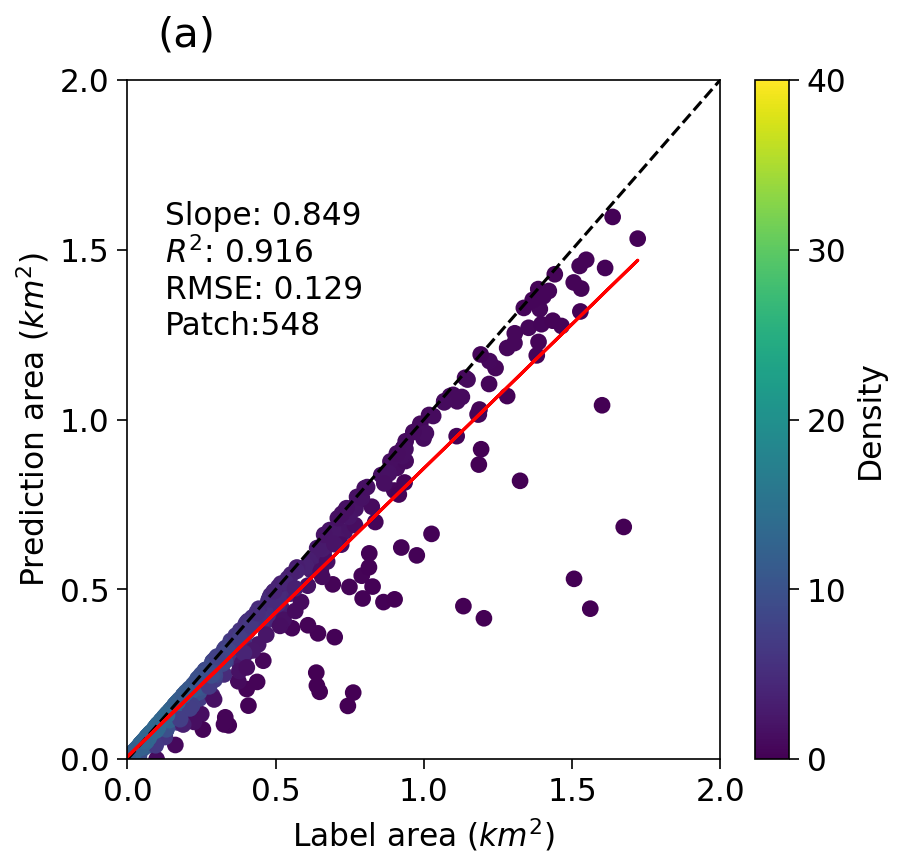

In [16]:
from scipy import optimize
from scipy import stats
from sklearn.metrics import mean_squared_error
%matplotlib inline
from matplotlib.pyplot import MultipleLocator
import matplotlib.ticker as ticker
from scipy.stats import gaussian_kde


fig, ax = plt.subplots(1,1, figsize=(6,6),dpi=150) 
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k')


plt.yticks(np.linspace(0, 2, 5))
plt.xticks(np.linspace(0, 2, 5))
plt.xlim(0,2)
plt.ylim(0,2)

x = ha_label_plume_area_km2
y = ha_prediction_plume_area_km2
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
cax = ax.scatter(x,y,s=49,c=z, alpha=1, marker='o', vmin=0, vmax=40, cmap=plt.cm.viridis)

cb = fig.colorbar(cax, fraction=0.1, pad=0.05)
# tick_locator = ticker.MaxNLocator(nbins=5)
cb.set_ticks(np.linspace(0, 40, num=5))
cb.set_label(label='Density', fontsize=15)
cb.ax.tick_params(length=5, labelsize=15)
# cb.update_ticks

ax.tick_params(axis='both', length=5, labelsize=15)
# labels = ax.get_xticklabels() + ax.get_yticklabels()
# [label.set_fontname('Arial') for label in labels]

res = stats.linregress(x, y) 

plt.plot(x, res.intercept + res.slope*np.array(x), 'r')
RMSE = mean_squared_error(ha_label_plume_area_km2, ha_prediction_plume_area_km2, squared=False)#RMSE

# ax.text(1,65,'${Slope}$'+'={:.6f}'+'\n${R^2}$'+'={:.3f}'+'\n${RMSE}$'+'={:.3f}'.format(Slope,R2,RMSE),fontproperties='Times New Roman')
ax.text(0.125,1.25,f"Slope: {res.slope:.3f}\n$R^2$: {res.rvalue**2:.3f}\nRMSE: {RMSE:.3f}\nPatch:{len(ha_label_plume_area_km2)}", fontsize=15) 
ax.annotate('(a)', (0.05, 1.05), xycoords='axes fraction', fontsize=20)

ax.set_xlabel('Label area (${km^2}$)', labelpad=4, fontsize=15)   
ax.set_ylabel('Prediction area (${km^2}$)', labelpad=4, fontsize=15)
plt.show()

In [17]:
fig.savefig(r'I:\results\SST\landsat\chart\test_scatter50.tif', dpi=300)

In [26]:
patch_area_df = pd.DataFrame({
    'ha_label_plume_area_km2': ha_label_plume_area_km2,
    'ha_prediction_plume_area_km2': ha_prediction_plume_area_km2,
})#+++++++++++++++++++++++++++++++++++++++++++++++++++++++#+++++++++++++++++++++++++++++++++++++++++++++++++++++++
patch_area_df.to_csv(r'I:\results\SST\landsat\evaluationreport\core50_patch_area_km2.csv') #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [27]:
# Generate the final report

report['count_correlation'] =  ha_count_correlation[0]
report['count_correlation_tvalue'] =  ha_count_correlation[1]
report['area_correlation'] = ha_area_correlation[0]
report['area_correlation_tvalue'] =  ha_area_correlation[1]

print(report)

tdf = pd.DataFrame(report, index=[0])    
# print(tdf.columns)
col_beginning = ['model_path','test_frame_dir', 'total_patch_count', 'accuracy', 'sensitivity']
col_rest = [x for x in tdf.columns.tolist() if x not in col_beginning]
cols = col_beginning + col_rest
tdf = tdf[cols]
tdf.to_csv(evaluation_report_filename)

{'loss': 0.10004705935716629, 'dice_coef': 0.9975225925445557, 'dice_loss': 0.0024774549528956413, 'accuracy': 0.9977720975875854, 'specificity': 0.9989474415779114, 'sensitivity': 0.8959949016571045, 'PA': 0.9977837800979614, 'IoU_Pos': 0.8207720518112183, 'IoU_Neg': 0.9977608919143677, 'mIoU': 0.9092664122581482, 'F1_Score': 0.8998980522155762, 'model_path': 'I:\\Unet\\v1\\v1\\notebooks\\saved_models\\UNet\\plumes_normalized_20220106-2216_adam_focalTversky_012_256.h5', 'test_frame_dir': 'I:\\Unet\\v1\\v1\\notebooks', 'total_patch_count': 548, 'count_correlation': 0.1772872378891899, 'count_correlation_tvalue': 2.9953619536845294e-05, 'area_correlation': 0.9751122755453413, 'area_correlation_tvalue': 0.0}
